In [2]:

import copy
import datetime
import os
os.chdir("/home/zhenjia/dev/folding-unfolding/src/")
import pathlib
import pickle as pkl
import sys
import time 

sys.path.append('/home/alper/folding-unfolding/src/PyFlex/bindings/build')
os.environ['PYFLEXROOT'] = '/home/alper/folding-unfolding/src/PyFlex'
os.environ['PYTHONPATH'] = '/home/alper/folding-unfolding/src/PyFlex/bindings/build'
os.environ['LD_LIBRARY_PATH'] = '/home/alper/folding-unfolding/src/PyFlex/external/SDL2-2.0.4/lib/x64'

from itertools import product
from typing import Dict, Optional, Tuple

import cv2
import h5py
# import imutils
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm

import open3d as o3d
from learning.utils import deformable_distance
from learning.nets import Factorized_UNet, MaximumValuePolicy, generate_coordinate_map, transform
from pc_vis import *
import pandas as pd

from skimage import draw
from notebooks.visualization_utils import *
from real.utils import *
from realEnv import RealEnv

checkpoint_path =  "./manipulation_policies/unfold_rgb_latest_ckpt.pth"
ckpt = torch.load(checkpoint_path, map_location='cpu')
policy = MaximumValuePolicy(
    action_primitives=['place', 'fling'],
    num_rotations = 16,
    scale_factors = [1.0, 1.5, 2.0, 2.5, 3.0],
    obs_dim = 128,
    pix_grasp_dist = 16,
    pix_drag_dist = 16,
    pix_place_dist = 10,
    deformable_weight = 0.65,
    nocs_mode = "collapsed",
    network_gpus = [0, 0],
    action_expl_prob = 0,
    action_expl_decay = 0,
    value_expl_prob = 0,
    value_expl_decay = 0,
    dual_networks = None,
    input_channel_types = 'rgb_pos',
    deformable_pos = True,
    dump_network_inputs=False,
)
policy.load_state_dict(ckpt['net'])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Policy] Action primitives:
	place
	fling
[Policy] Primitive vmap indices: {'fling': [20, 60], 'place': [0, 75]}
[Policy] NOCS mode collapsed
[Network] Initializing with inputs: rgb_pos
[Network] Initializing factorized network
[Network] Giving deformable network positional encoding
[Policy] Network starting with value exploration


<All keys matched successfully>

Dataset length: 83
000000000_step00
<KeysViewHDF5 ['action_mask', 'actions', 'all_obs', 'fling', 'fling_deformable_vmap', 'fling_mask', 'fling_rigid_vmap', 'fling_valid_pixels', 'observations', 'place', 'place_deformable_vmap', 'place_mask', 'place_rigid_vmap', 'place_valid_pixels', 'pretransform_observations', 'value_map']>
(102, 9, 128, 128)


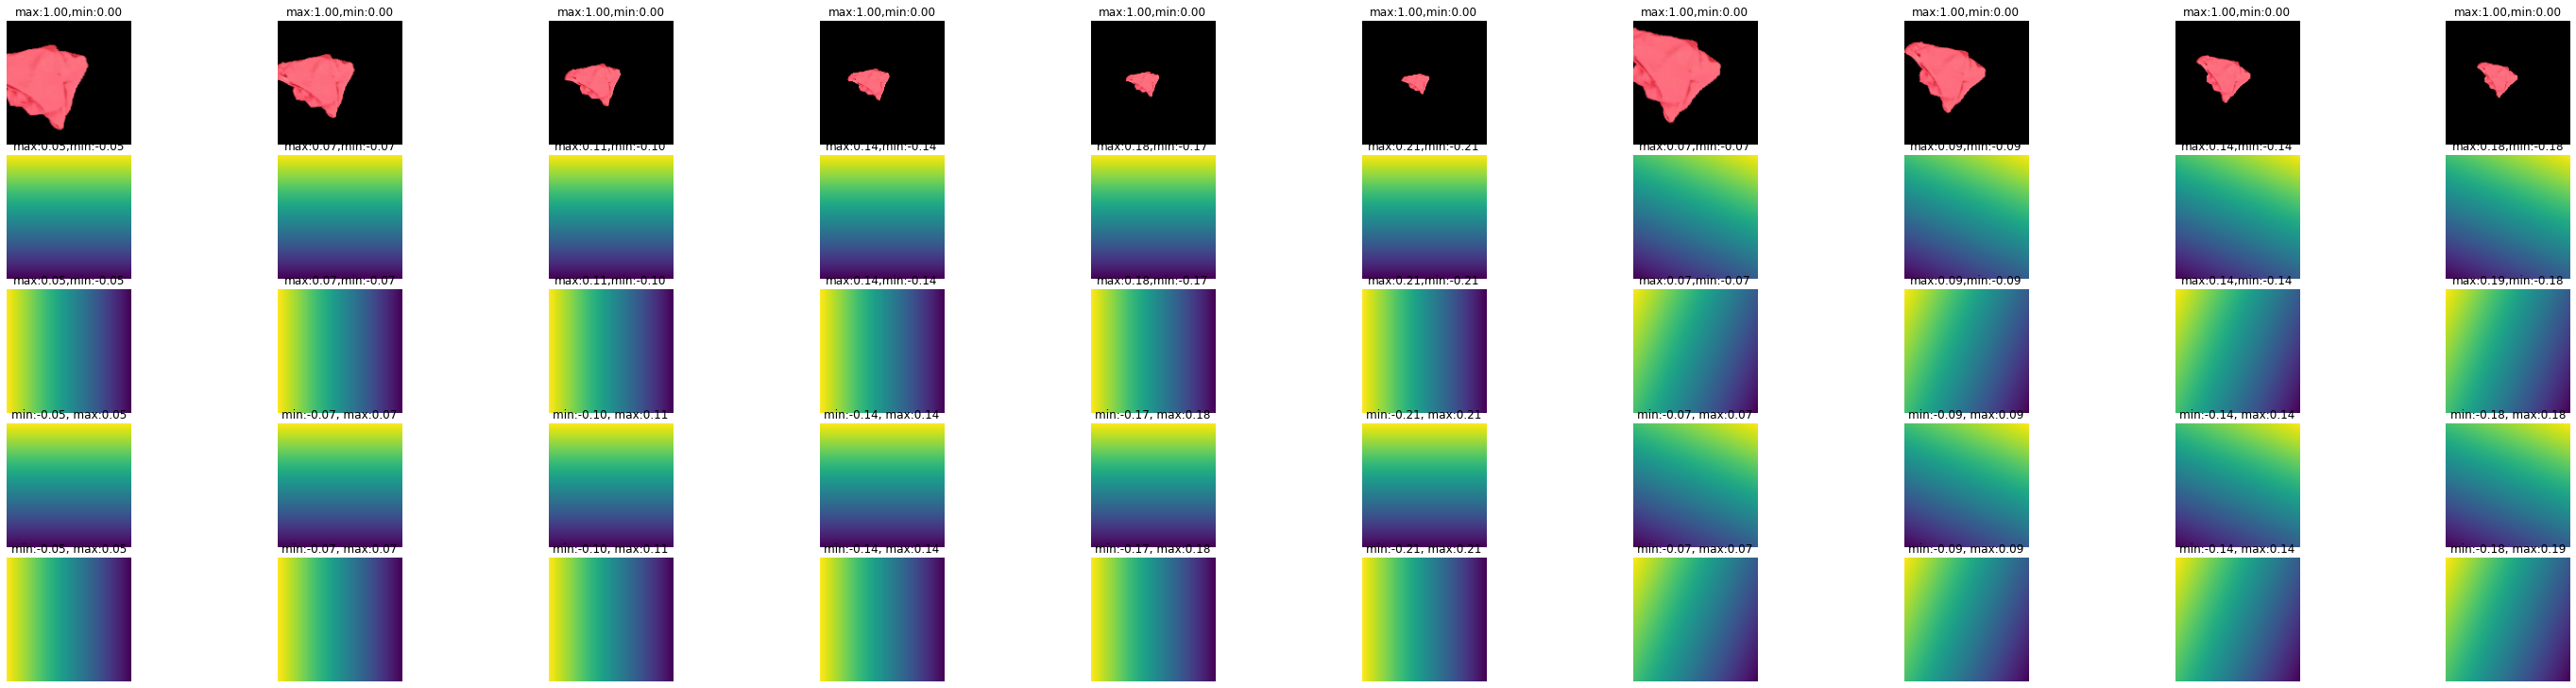

valid pixels shape (102, 128, 128)


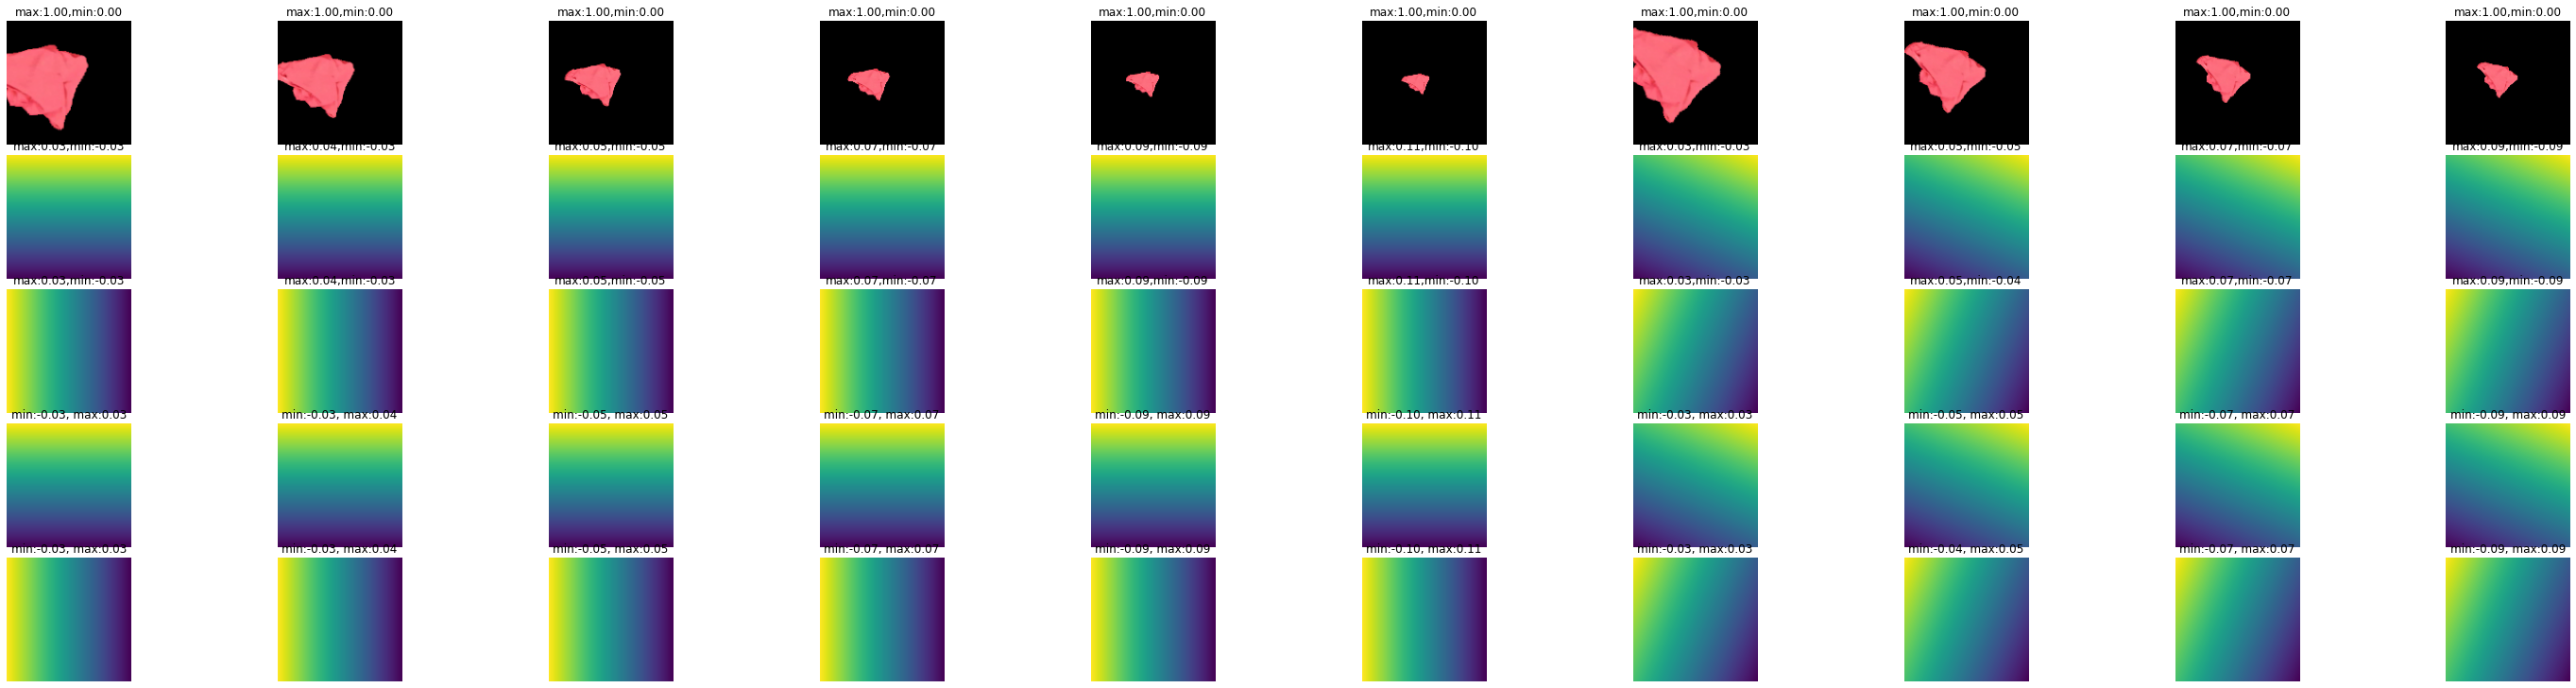

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [6]:
dataset_path = "/home/zhenjia/dev/folding-unfolding/src/0806-real/0-0-0_attempt2/replay_buffer.hdf5"
ep_len = 6



def transformation(tensor):
    # rgb = tensor[:, :3, :, :].transpose(0, 2, 3, 1)
    # print("rgb shape", rgb.shape)
    # edges = cv2.Canny((rgb*255).astype(np.uint8), 5, 10)
    # edges = (1-(edges/255)).astype(np.int32)
    # print("edges shape", edges.shape)
    # rgb[edges] = 0
    tensor[:, -2:, :, :] /= 2

    return tensor

print("Dataset length:", len(dataset_path))
with h5py.File(dataset_path, "r") as dataset:
    for i, k in zip(range(400), dataset):
        ep = int(k.split("_")[0])
        step = int(k.split("_")[1][4:])

        # if ep:
        #     continue
        group = dataset[k]

        print(k)
        print(group.keys())
        print(group['place'].shape)
        visualize_input(np.array(group['place']))

        for primitive in ['place', 'fling']:
            pretransform = group['pretransform_observations']
            new_input = transformation(np.array(group[primitive]))
            valid_pixels = np.array(group[f'{primitive}_valid_pixels'])

            print("valid pixels shape", valid_pixels.shape)
            visualize_input(new_input)
            network_vmaps, masks = policy.get_action_single(torch.tensor(new_input).float())
            vmaps = {'rigid': None, 'deformable': None}
            network_vmaps = {'rigid': network_vmaps['rigid'], 'deformable': network_vmaps['deformable']}
            for distance in 'rigid', 'deformable':
                # network_vmap = np.array(network_vmaps[distance][primitive].detach().cpu().numpy())
                vmap = np.array(group[f"{primitive}_{distance}_vmap"])
                mask = np.array(group[primitive][:, :3, ... ].sum(axis=1) > 0)
                vmaps[distance] = np.array(vmap)

            deformable_weight = 0.7
            vmap = vmaps['deformable'] * deformable_weight + vmaps['rigid'] * (1-deformable_weight)
            # network_vmap = network_vmaps['deformable'][primitive].cpu().detach().numpy() * deformable_weight + network_vmaps['rigid'][primitive].cpu().detach().numpy() * (1-deformable_weight)
            
            
            # print("Network vmap:", network_vmap.shape)
            # # visualize_vmaps(network_vmap, masks=mask, mask_fill=vmap[mask].min(), title=(primitive + "_" + distance + "_network"), num_scales=5)
            # network_vmap = network_vmap.squeeze(1)
            # network_vmap[~valid_pixels] = -torch.inf
            # net_max_value_index = np.unravel_index(np.argmax(network_vmap), shape=network_vmap.shape)
            # print("Network max index", net_max_value_index)

            # rgb_img = group[primitive][net_max_value_index[0], :3, :, :].transpose(1, 2, 0)
            # p = net_max_value_index[1:][::-1]
            # if primitive == "fling":
            #     p1, p2 = p + np.array([0, 16]),  p + np.array([0, -16])
            #     rgb_img = draw_fling(rgb_img, p1, p2)
            # elif primitive == "place":
            #     p1, p2 = p, p  + np.array([0, 10])
            #     rgb_img = draw_place(rgb_img, p1, p2)

            # fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            # axs[0].imshow(rgb_img)
            # axs[1].imshow(valid_pixels[net_max_value_index[0]])
            # axs[0].set_title(f"{primitive}_{distance}_network: {network_vmap[net_max_value_index]:.2f}")
            # # plt.imshow(rgb_img)
            # plt.show()


            print("Ground truth vmap:", vmap.shape)
            visualize_vmaps(vmap, masks=mask, mask_fill=vmap[mask].min(), title=(primitive + "_" + distance + "_ground_truth"), num_scales=5)
            vmap[~valid_pixels] = -torch.inf
            gt_max_value_index = np.unravel_index(np.argmax(vmap), shape=vmap.shape)
            print("Gt max index", gt_max_value_index)

            rgb_img = group[primitive][gt_max_value_index[0], :3, :, :].transpose(1, 2, 0)
            p = gt_max_value_index[1:][::-1]
            if primitive == "fling":
                p1, p2 = p + np.array([0, 16]),  p + np.array([0, -16])
                rgb_img = draw_fling(rgb_img, p1, p2)
            elif primitive == "place":
                p1, p2 = p, p  + np.array([0, 10])
                rgb_img = draw_place(rgb_img, p1, p2)


            # fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            # axs[0].imshow(rgb_img)
            # axs[1].imshow(valid_pixels[gt_max_value_index[0]])
            # axs[0].set_title(f"{primitive}_{distance}_gt: {vmap[gt_max_value_index]:.2f}")
            # # plt.imshow(rgb_img)
            # plt.show()

            time.sleep(5)

           
            # deformable_vmap = np.array(group['fling_deformable_vmap'])
            # rigid_vmap = np.array(group['fling_rigid_vmap'])
            # mask = np.array(group['fling_mask'])
            # visualize_vmaps(place_rigid_vmap, masks=place_mask, mask_fill=place_rigid_vmap[place_mask].min())

            
